Sebelum menjalankan notebook ini, pastika dependencies library sudah terpenuhi dengan melakukan instalasi sebagai berikut : 

```bash
$pip install pandas matplotlib librosa pitch tqdm
```

Dan optional untuk menginstall praatio
```bash
$pip install praatio
```

In [149]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import librosa.display
import pitch

from tqdm import tqdm
from sklearn.model_selection import train_test_split
# from praatio import tgio optional untuk word framing

import os
from os import walk 
import re

# Data Preparation

In [123]:
files = []
for (dirpath, dirnames, filenames) in walk('data'):
    files.extend(filenames)
    break

In [124]:
_data = re.findall('(\d+)_([a-zA-Z]+)_(\d+)\.wav', '\n'.join(files))
data = pd.DataFrame(_data, columns=['word', 'person', 'number'])
data['filename'] = re.findall('\d+_[a-zA-Z]+_\d+\.wav', '\n'.join(files))

In [125]:
data.head(3)

,word,person,number,filename
0,5,nicolas,9,5_nicolas_9.wav
1,3,yweweler,14,3_yweweler_14.wav
2,4,yweweler,38,4_yweweler_38.wav


Setelah datanya siap, kita akan mengelompokkan data menjadi : 
- Data Latih 60%
- Data Validasi 20%
- Data Uji 20%

In [163]:
# Saat ini belum dibutuhkan
# X_train, X_test, y_train, y_test = train_test_split(data, data['person'], test_size=0.2, random_state=100)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=100) # 0.25 x 0.8 = 0.2

# Export Sample Data Information
Untuk mempermudah proses klasifikasi, kita akan melakukan ekstraksi dari data yang sudah ada berupa : 
- pitch, 
- formant
- spectogram

Berikut adalah s=contoh ekstraksi terhadap sebuah data (menggunakan data pertama yang terdaftar di DataFrame sebagai sampel)

In [127]:
# load data pertama
i = 0
audio_data = f"data/{X_train['filename'].iloc[i]}"
audio_array, audio_sr = librosa.load(audio_data, sr=44100)

In [128]:
import IPython.display as ipd
ipd.Audio(audio_data)

In [129]:
print(f"Data Duration is: {len(audio_array)/audio_sr} seconds")

Data Duration is: 0.4753968253968254 seconds


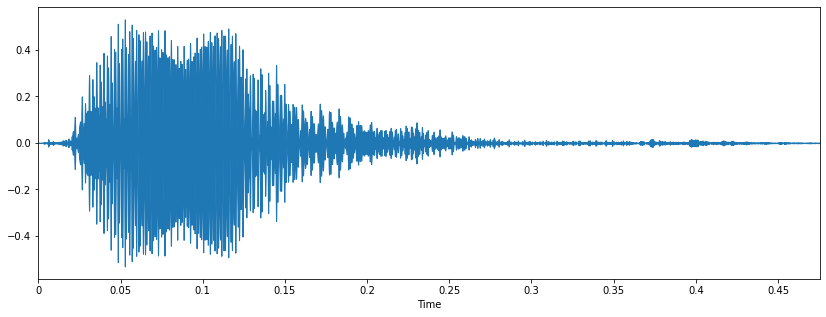

In [130]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio_array, sr=44100)

## Ekstrak Pitch
Untuk mengekstrak pitch, kita dapat menggunakan pitch

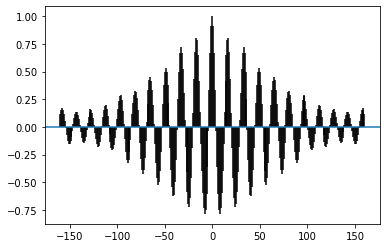

In [131]:
p = pitch.find_pitch(audio_data)

In [132]:
p #p akan disimpan 

421.05263157894734

# Formant
Untuk mendapatkan formant dan spectogram, kita akan menggunakan metode *Short Time Fourier Transform* (STFT) dari library `librosa`  dan *Fast Fourier Transrom* (FFT) dari `scipy`. 
Untuk data yang berukuran kecil, sangat disarankan untuk menggunakna *Short Time Fourier Transform*.

In [133]:
import scipy

def fft_plot(audio_array, audio_sr, method='fft'):
    n = len(audio_array)
    T = 1/audio_sr
    if method == 'stft':
        yf = librosa.stft(audio_array).flatten()[:n]
        xf= np.linspace(0.0, 1.0/(2.0*T) , n)
        fix, ax = plt.subplots()
        ax.plot(xf, 2/n * np.abs(yf[:n]))
        plt.grid()
        plt.show()
        return yf

    else:
        yf= scipy.fft.fft(audio_array)
        xf= np.linspace(0.0, 1.0/(2.0*T) , n//2)
        fix, ax = plt.subplots()
        ax.plot(xf, 2/n * np.abs(yf[:n//2]))
        plt.grid()
        plt.show()
        return yf

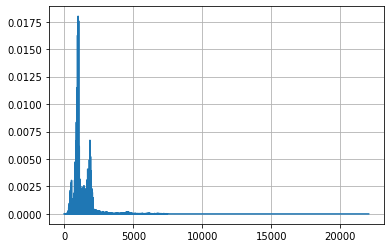

In [134]:
audio_stft_raw = librosa.stft(audio_array)
audio_stft = fft_plot(audio_array, audio_sr, method='stft')

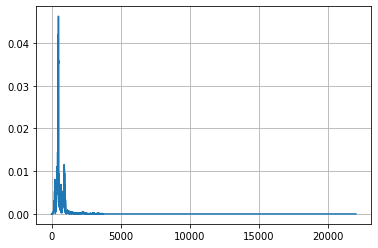

In [135]:
audio_fft = fft_plot(audio_array, audio_sr, method='fft')

In [136]:
print(f"""STFT Raw Size : {audio_stft_raw.shape}
STFT Size : {audio_stft.shape}
FFT Size : {audio_fft.shape}
""")

STFT Raw Size : (1025, 41)
STFT Size : (20965,)
FFT Size : (20965,)



# Spectorgram
Kita akan membuat spectogram dari stft

In [137]:
Xdb = librosa.amplitude_to_db(abs(audio_stft_raw))

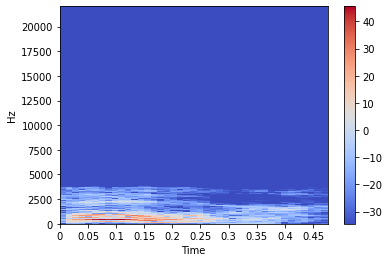

In [138]:
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
plt.colorbar()

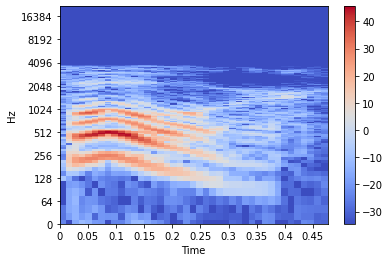

In [139]:
# log frequency untuk memadatkan file. Berguna untuk visualisasi saja 
librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='log')
plt.colorbar()

# Export Whole Data Information

Kita akan mengupdate dataframe dengan : 
- pitch
- lokasi file forman
- lokasi file spektogram

2000it [06:08,  5.43it/s]


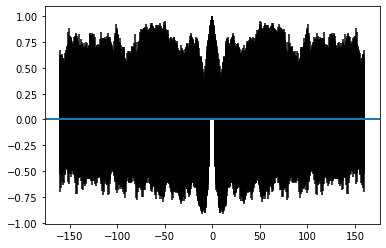

In [162]:
pitches = []
for idx, row in tqdm(data.iloc[:].iterrows()):
    # load audio file 
    audio_data = f"data/{row['filename']}"
    audio_array, audio_sr = librosa.load(audio_data, sr=44100)
    
    # extract pitch, simpan nilai ke list 
    pitches.append(pitch.find_pitch(audio_data))
    
    # extract formant, simpan ke file
    audio_stft_raw = librosa.stft(audio_array)
    audio_stft = audio_stft_raw.flatten()[:len(audio_array)]
    
    filename = f"formant/{str(row['word'])}_{str(row['person'])}_{str(row['number'])}_formant.csv"
    np.savetxt(filename, audio_stft, delimiter=",")
    
    # exract spectogram, simpan ke file
    filename = f"spectogram/{str(row['word'])}_{str(row['person'])}_{str(row['number'])}_specto.csv"
    specto = librosa.amplitude_to_db(abs(audio_stft_raw))
    np.savetxt(filename, audio_stft, delimiter=",")

# update dataframe
data['picth'] = pitches

In [164]:
data.to_csv('dataset.csv')